# 利用機器學習實現河川水位預測

以下取用並改編自
http://khanwhlee.blogspot.tw/2016/08/scikit.html

## 1. 載入套件

In [1]:
import pandas as pd # 處理表格
import numpy as np # 科學運算
import matplotlib.pyplot as plt # 畫圖
import matplotlib as mpl # 畫圖
from datetime import timedelta, datetime # 時間處理
from sklearn import model_selection, svm # 機器學習套件
from sklearn.linear_model import LinearRegression # 機器學習套件
from sklearn.ensemble import RandomForestRegressor # 機器學習套件

## 2. 載入資料
* 因這幾個 csv 檔含有繁體中文，需要以big5編碼開啟，na_values在檔案中是以中文字的'缺測'表示，同樣需要以big5編碼

In [2]:
df1 = pd.read_csv('files/C_waterlevel.csv', encoding='big5', na_values='缺測'.encode('big5')) # C測站水位資料
df2 = pd.read_csv('files/W_waterlevel.csv', encoding='big5', na_values='缺測'.encode('big5')) # W測站水位資料
df3 = pd.read_csv('files/CT_rainfall.csv', encoding='big5') # CT測站雨量資料
df4 = pd.read_csv('files/DS_rainfall.csv') # DS測站雨量資料

In [3]:
df1.head()

,changrenchiao,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2014/1/1 上午 12:00:00,0.34,0.20,0.13,0.11,0.12,0.12,0.18,0.29,0.33,...,0.34,0.48,0.67,0.86,0.96,1.01,1.01,1.01,0.89,0.66
1,2014/1/2 上午 12:00:00,0.46,0.27,0.15,0.10,0.11,0.11,0.12,0.22,0.28,...,0.32,0.35,0.54,0.74,0.91,1.01,1.04,1.04,1.03,0.86
2,2014/1/3 上午 12:00:00,0.61,0.42,0.24,0.14,0.12,0.11,0.11,0.17,0.26,...,0.33,0.32,0.37,0.58,0.74,0.89,0.97,0.98,0.98,0.95
3,2014/1/4 上午 12:00:00,0.75,0.53,0.35,0.18,0.11,0.10,0.10,0.11,0.18,...,0.35,0.35,0.35,0.36,0.49,0.64,0.77,0.83,0.84,0.84
4,2014/1/5 上午 12:00:00,0.82,0.62,0.41,0.28,0.15,0.12,0.11,0.12,0.12,...,0.40,0.40,0.39,0.39,0.39,0.46,0.60,0.67,0.71,0.73


In [4]:
df3.head()

,chiaoto,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2014/1/1 上午 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014/1/2 上午 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014/1/3 上午 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014/1/4 上午 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014/1/5 上午 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. 處理資料
將第一個欄位名稱都改成 'time'

In [5]:
for i in [df1, df2, df3, df4]:
    i.columns.values[0] = 'time'

#### 目前是列是日期，欄是一天的每個小時，之後要把每個小時都接在一起
#### 每天最後一小時接上隔天的第一個小時，把二維的資料整理成一維，就可以將四個表格整理在一份裡面了

In [6]:
df1.head()

,time,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2014/1/1 上午 12:00:00,0.34,0.20,0.13,0.11,0.12,0.12,0.18,0.29,0.33,...,0.34,0.48,0.67,0.86,0.96,1.01,1.01,1.01,0.89,0.66
1,2014/1/2 上午 12:00:00,0.46,0.27,0.15,0.10,0.11,0.11,0.12,0.22,0.28,...,0.32,0.35,0.54,0.74,0.91,1.01,1.04,1.04,1.03,0.86
2,2014/1/3 上午 12:00:00,0.61,0.42,0.24,0.14,0.12,0.11,0.11,0.17,0.26,...,0.33,0.32,0.37,0.58,0.74,0.89,0.97,0.98,0.98,0.95
3,2014/1/4 上午 12:00:00,0.75,0.53,0.35,0.18,0.11,0.10,0.10,0.11,0.18,...,0.35,0.35,0.35,0.36,0.49,0.64,0.77,0.83,0.84,0.84
4,2014/1/5 上午 12:00:00,0.82,0.62,0.41,0.28,0.15,0.12,0.11,0.12,0.12,...,0.40,0.40,0.39,0.39,0.39,0.46,0.60,0.67,0.71,0.73


#### 填補空缺值，用前一個觀測值填入

In [7]:
df1.fillna(method='ffill', inplace=True)
df2.fillna(method='ffill', inplace=True)
df3.fillna(method='ffill', inplace=True)
df4.fillna(method='ffill', inplace=True)

#### 設定時間，以每小時為單位重新撰寫 'time' 欄位

In [8]:
starttime = datetime(2014, 1, 1, 0, 0, 0) #設定資料起始時間
interval = timedelta(hours=1) #設定縱軸間隔

print(starttime)

2014-01-01 00:00:00


In [9]:
time = [starttime + i * interval for i in range(len(df1) * 24)]

print(time[:3])

[datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2014, 1, 1, 1, 0), datetime.datetime(2014, 1, 1, 2, 0)]


#### 建立一個新的表格，將四個整理成一維的資料放入新的表格

In [10]:
# 取用時間欄位後面的欄位，1~24小時的部分，轉成 numpy array 後弄成一維 (ravel())
def ravel_table(x):
    return x.iloc[:,1:].as_matrix().ravel()

In [11]:
# 將四個一維 array 放入新的表格 df 中
# cl: C站水位, wl: W站水位, cr: CT站雨量, dr: DS站雨量
df = pd.DataFrame({'time': time, 'cl': ravel_table(df1), 'wl': ravel_table(df2),\
                   'cr': ravel_table(df3), 'dr': ravel_table(df4)})

df = df[['time', 'cl', 'wl', 'cr', 'dr']]
df.set_index('time', inplace=True)

In [12]:
df[df < 0] = 0 # 將小於零的空值(e.g., -999996.0)改成 0
df.fillna(0, inplace=True) # 將 nan 空值改成 0

In [13]:
df.head()

,cl,wl,cr,dr
time,,,,
2014-01-01 00:00:00,0.34,1.16,0.0,0.0
2014-01-01 01:00:00,0.20,1.16,0.0,0.0
2014-01-01 02:00:00,0.13,1.16,0.0,0.0
2014-01-01 03:00:00,0.11,1.17,0.0,0.0
2014-01-01 04:00:00,0.12,1.17,0.0,0.0


# 4. 分析資料

#### 從此圖可以大概看出CT和DS兩個雨量測站的變化很接近，而這wl水位測站的變化又與兩個雨量測站很接近

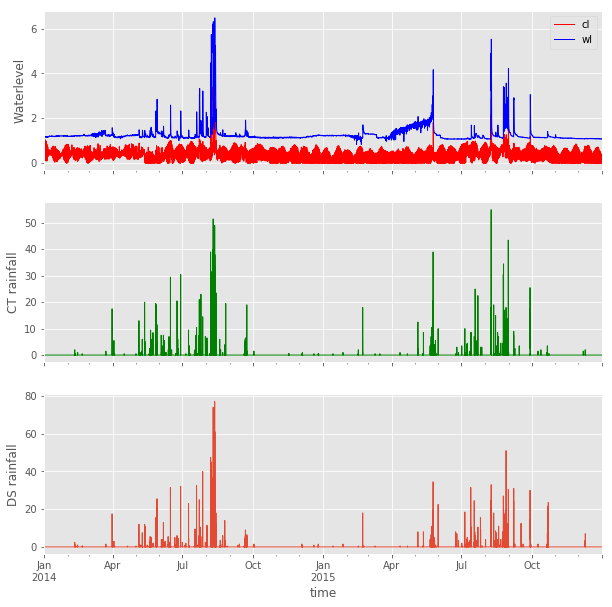

In [14]:
# 設定圖片大小
mpl.rcParams['figure.figsize'] = (10,10)
# 設定繪圖風格
plt.style.use('ggplot')
# 分割成 3X1
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0), sharex=ax1)
ax3 = plt.subplot2grid((3,1),(2,0), sharex=ax1)

df[['cl','wl']].plot(ax= ax1, linewidth = 1, color=['r','b'])
df['cr'].plot(ax= ax2, label="rf1", linewidth = 1, color='g')
df['dr'].plot(ax= ax3, label="rf2", linewidth = 1)

ax1.set_ylabel('Waterlevel')
ax2.set_ylabel('CT rainfall')
ax3.set_ylabel('DS rainfall')
plt.show()

#### 把最不相關的cl水位測站拿出來看，因為該測站在出海口附近，會受潮汐影響，因此不考慮使用此資料來學習

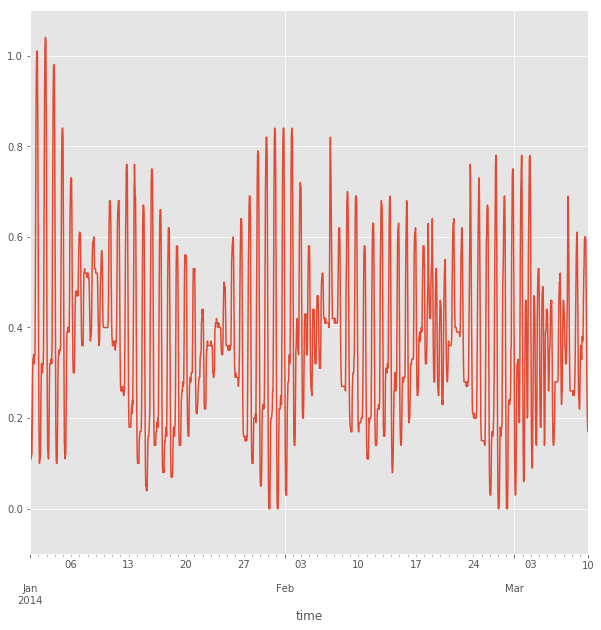

In [15]:
df['cl'].plot()
plt.xlim(datetime(2014, 1, 1, 0, 0, 0), datetime(2014, 3, 10, 0, 0, 0))
plt.ylim(-0.1, 1.1)
plt.show()

#### 加入 n 小時前的雨量統計，可用來分析例如兩小時前的雨量會不會影響到現在的水位變化

In [16]:
# 設定從 1 小時前到 10 小時前
for i in range(1,11):
    df['cr'+str(i)] = df['cr'].shift(i) # CT rainfall
    df['dr'+str(i)] = df['dr'].shift(i) # DAS rainfall
    df['wl'+str(i)] = df['wl'].shift(i)

df.fillna(0, inplace=True)

In [17]:
df.head(2)

,cl,wl,cr,dr,cr1,dr1,wl1,cr2,dr2,wl2,...,wl7,cr8,dr8,wl8,cr9,dr9,wl9,cr10,dr10,wl10
time,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.34,1.16,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,0.20,1.16,0.0,0.0,0.0,0.0,1.16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 將各個欄位做相關性分析，該值為相關係數，愈接近1愈相關
* 可以發現 CT雨量站(cr) 和 DS雨量站(dr) 相關係數很大，所以後面只使用CT雨量站(cr)的資料即可
* 因為 C水位測站受潮汐影響，故只比較 wl 及 n 小時前的雨量統計
* 取用 wl1(1小時前水位). wl2(2小時前水位). cr2(2小時前雨量) ~ cr6(6小時前雨量) 作為特徵來訓練
* 取 cr2 ~ cr6 是根據其相關係數大於 0.5

In [18]:
df.corr()[['cl', 'wl', 'cr', 'dr']]

,cl,wl,cr,dr
cl,1.000000,0.505533,0.271781,0.248376
wl,0.505533,1.000000,0.334832,0.303953
cr,0.271781,0.334832,1.000000,0.811389
dr,0.248376,0.303953,0.811389,1.000000
cr1,0.316255,0.409174,0.512601,0.503715
dr1,0.289469,0.383799,0.486403,0.499940
wl1,0.493881,0.981530,0.299975,0.262872
cr2,0.359865,0.506937,0.292997,0.283279
dr2,0.337294,0.485641,0.277923,0.272732
wl2,0.467341,0.939548,0.282220,0.244212


#### 試著畫出水位與4小時前雨量的對應圖

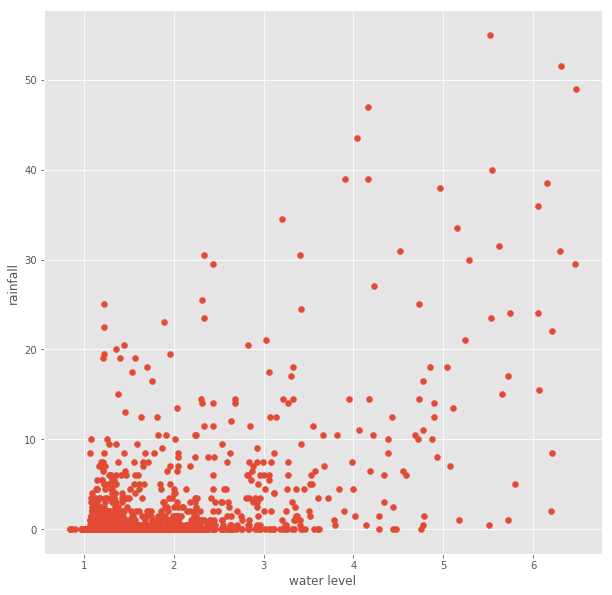

In [19]:
plt.scatter(df['wl'], df['cr4'])
plt.xlabel('water level')
plt.ylabel('rainfall')
plt.show()

# 5. 使用機器學習

#### 設定 輸入值 (X) 與 對應值 (y)

In [20]:
df_feature = df[['wl1', 'wl2', 'cr2', 'cr3', 'cr4', 'cr5', 'cr6']]
X = np.array(df_feature)
y = np.array(df['wl'])

#### 分割 訓練組 (90%) 與 測試組 (10%)

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=0)

#### 設定訓練方式
* Linear Regression: 速度快，準確度高，約 0.969
* Support Vector Regression (SVR): kernel 為 rbf 時可以很快，若改成 poly 會超慢，準確度差，前者的準確度約為 0.769，後者未知
* Random Forest Regression: 速度快，準確度高，約 0.954

In [22]:
clf = LinearRegression(n_jobs=-1)
# clf = svm.SVR()
# clf = RandomForestRegressor(n_estimators = 10, random_state = 0, n_jobs=-1)

clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

#### 評分，計算準確度

In [23]:
accuracy = clf.score(X_test, y_test)

print ('two hours in advance')
print ('accuracy,', round(accuracy, 3))

two hours in advance
accuracy, 0.969


#### 讀取額外資料來做預測，測試模型準確程度

In [24]:
def read_predict_file(file_name, start, stop_condition):

    df = pd.read_csv(file_name, encoding='big5', usecols=range(3))
    df.columns = ['time2','waterlevel','rainfall']
    df.drop(['time2'], 1, inplace=True)
    df[df < 0] = 0
    df['daysvalue'] = df['rainfall'].rolling(window = stop_condition).mean()
    df.fillna(0.00000001, inplace=True)

    df = df[df['daysvalue']>0]
    #print (df)
    time_index = []
    startpoint = datetime(start[0],start[1],start[2],start[3],0,0)
    for i in range(len(df.index)):
        time_index.append(startpoint)
        startpoint += interval
    df['time'] = pd.Series(time_index, index = df.index)
    df.set_index('time', inplace=True)
    df[df < 0] = 0

    for i in range(2,8):
        df['rainfall'+str(i)] = df['rainfall'].shift(i)

    df['waterlevel1'] = df['waterlevel'].shift(1)
    df['waterlevel2'] = df['waterlevel'].shift(2)
    #df['waterlevel3'] = df['waterlevel'].shift(3)

    df.dropna(inplace=True)

    return df

In [25]:
df_0610 = read_predict_file('files/0610rain.csv', [2016, 6, 10, 0], 48)
df_0706 = read_predict_file('files/0706rain.csv', [2016, 7, 6, 0], 48)

In [26]:
df_0610.head()

,waterlevel,rainfall,daysvalue,rainfall2,rainfall3,rainfall4,rainfall5,rainfall6,rainfall7,waterlevel1,waterlevel2
time,,,,,,,,,,,
2016-06-10 07:00:00,1.17,0.0,1.000000e-08,0.0,0.0,0.0,0.0,0.0,10.0,1.17,1.17
2016-06-10 08:00:00,1.17,0.5,1.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0,1.17,1.17
2016-06-10 09:00:00,1.17,0.0,1.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0,1.17,1.17
2016-06-10 10:00:00,1.17,0.0,1.000000e-08,0.5,0.0,0.0,0.0,0.0,0.0,1.17,1.17
2016-06-10 11:00:00,1.17,0.0,1.000000e-08,0.0,0.5,0.0,0.0,0.0,0.0,1.17,1.17


#### 預測並計算誤差

In [27]:
def predict_df(df, clf):
    # ------------------預測------------------
    # 輸入特徵值
    df_feature_predict_me = df[['waterlevel1', 'waterlevel2','rainfall2','rainfall3','rainfall4','rainfall5','rainfall6']]
    # 轉成 numpy array
    X_predict_me = np.array(df_feature_predict_me)
    # 用上面完成的模型來預測 輸入 X 得到 y
    forecast_set = clf.predict(X_predict_me)
    # 將預測出來的值在原有表格新增一個欄位放進去
    df['predict_wl'] = pd.Series(forecast_set, index = df.index)
    # ----------------------------------------
    
    # ------------------算誤差-----------------
    error_sum = 0
    error_com_sum = 0
    error_square_sum = 0
    com_error_square_sum = 0
    
    for i in range(len(df.index)):
        error_square = ((df['predict_wl'][i] - df['waterlevel'][i]) ** 2)
        error_square_sum += error_square
        com_error_square = ((df['waterlevel2'][i] - df['waterlevel'][i]) ** 2)
        com_error_square_sum += com_error_square

    rmse = np.sqrt(error_square_sum / len(df.index))
    brmse = np.sqrt(com_error_square_sum / len(df.index))
    print ('RMS error:', round(rmse*100, 2), 'cm')
    # ----------------------------------------

#### 從下圖右邊可以看到藍色的預測值與實際的紅色值差不多，訓練的結果還算不錯

6/10
RMS error: 9.05 cm
7/6
RMS error: 12.29 cm


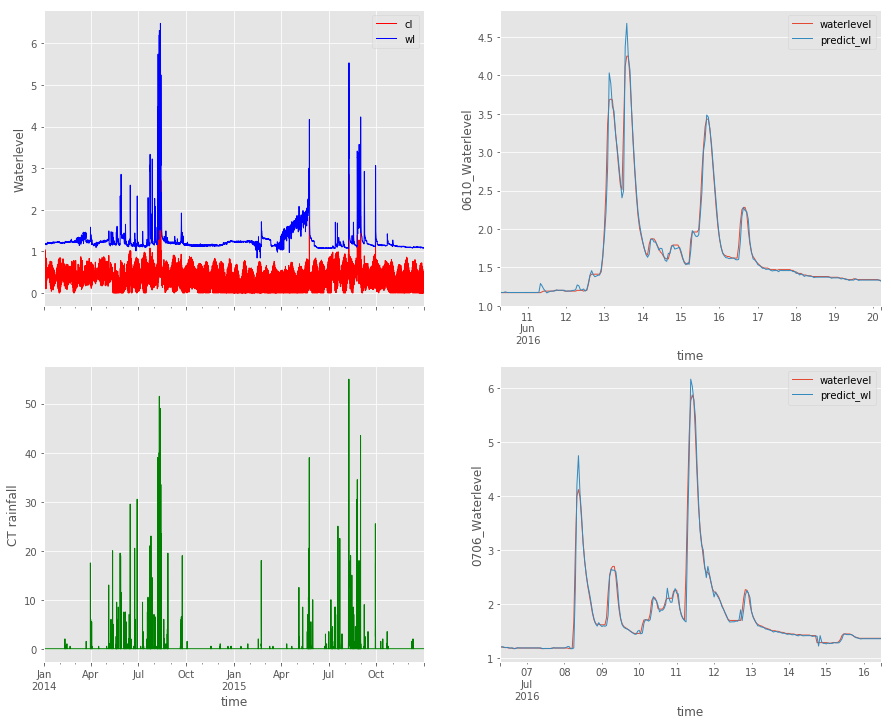

In [28]:
# 設定圖片大小
mpl.rcParams['figure.figsize'] = (15,12)
# 分割成 2X2 四格 
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(1,0), sharex=ax1)
ax3 = plt.subplot2grid((2,2),(0,1))
ax4 = plt.subplot2grid((2,2),(1,1))

df[['cl','wl']].plot(ax= ax1, linewidth = 1, color=['r','b'])
df['cr'].plot(ax= ax2, label="rf1", linewidth = 1, color='g')

ax1.set_ylabel('Waterlevel')
ax2.set_ylabel('CT rainfall')

print ('6/10')
predict_df(df_0610, clf)
df_0610[['waterlevel','predict_wl']].plot(ax= ax3, linewidth = 1)
ax3.set_ylabel('0610_Waterlevel')

print ('7/6')
predict_df(df_0706, clf)
df_0706[['waterlevel','predict_wl']].plot(ax= ax4, linewidth = 1)
ax4.set_ylabel('0706_Waterlevel')

plt.show()

# 6. 儲存訓練好的機器學習模型

In [29]:
from sklearn.externals import joblib # 可用來儲存模型的套件

# 儲存模型 (第一個參數放模型，第二個放要存成的檔名)
joblib.dump(clf, 'files/clf.pkl')

['clf.pkl']

# 7. 讀取之前訓練的模型

In [30]:
clf_new = joblib.load('files/clf.pkl')

#### 把原本的 predict_df(df_0610, clf) 改成 predict_df(df_0610, clf_new) 測試是否讀取成功

6/10
RMS error: 9.05 cm
7/6
RMS error: 12.29 cm


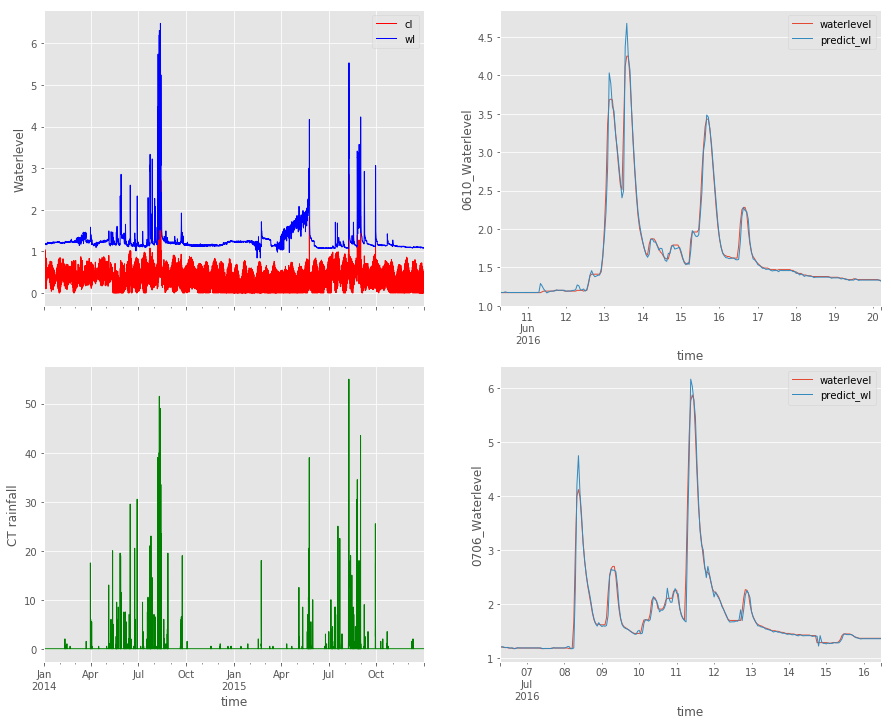

In [31]:
# 設定圖片大小
mpl.rcParams['figure.figsize'] = (15,12)
# 分割成 2X2 四格 
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(1,0), sharex=ax1)
ax3 = plt.subplot2grid((2,2),(0,1))
ax4 = plt.subplot2grid((2,2),(1,1))

df[['cl','wl']].plot(ax= ax1, linewidth = 1, color=['r','b'])
df['cr'].plot(ax= ax2, label="rf1", linewidth = 1, color='g')

ax1.set_ylabel('Waterlevel')
ax2.set_ylabel('CT rainfall')

print ('6/10')
predict_df(df_0610, clf_new)
df_0610[['waterlevel','predict_wl']].plot(ax= ax3, linewidth = 1)
ax3.set_ylabel('0610_Waterlevel')

print ('7/6')
predict_df(df_0706, clf_new)
df_0706[['waterlevel','predict_wl']].plot(ax= ax4, linewidth = 1)
ax4.set_ylabel('0706_Waterlevel')

plt.show()

# 完成！